필기체 이미지를 입력으로 받아 그것의 핵심을 자동으로 뽑아 차원을 줄여서 중간 층에 저장하고 다시 복원하여 입력과 비슷하게 출력하는 auto encoder 에 대해서 알아봅시다. 레이블 데이터는 필요가 없으므로 변수로 저장할 필요가 없습니다.

train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8
test_images <class 'numpy.ndarray'> (10000, 28, 28) uint8


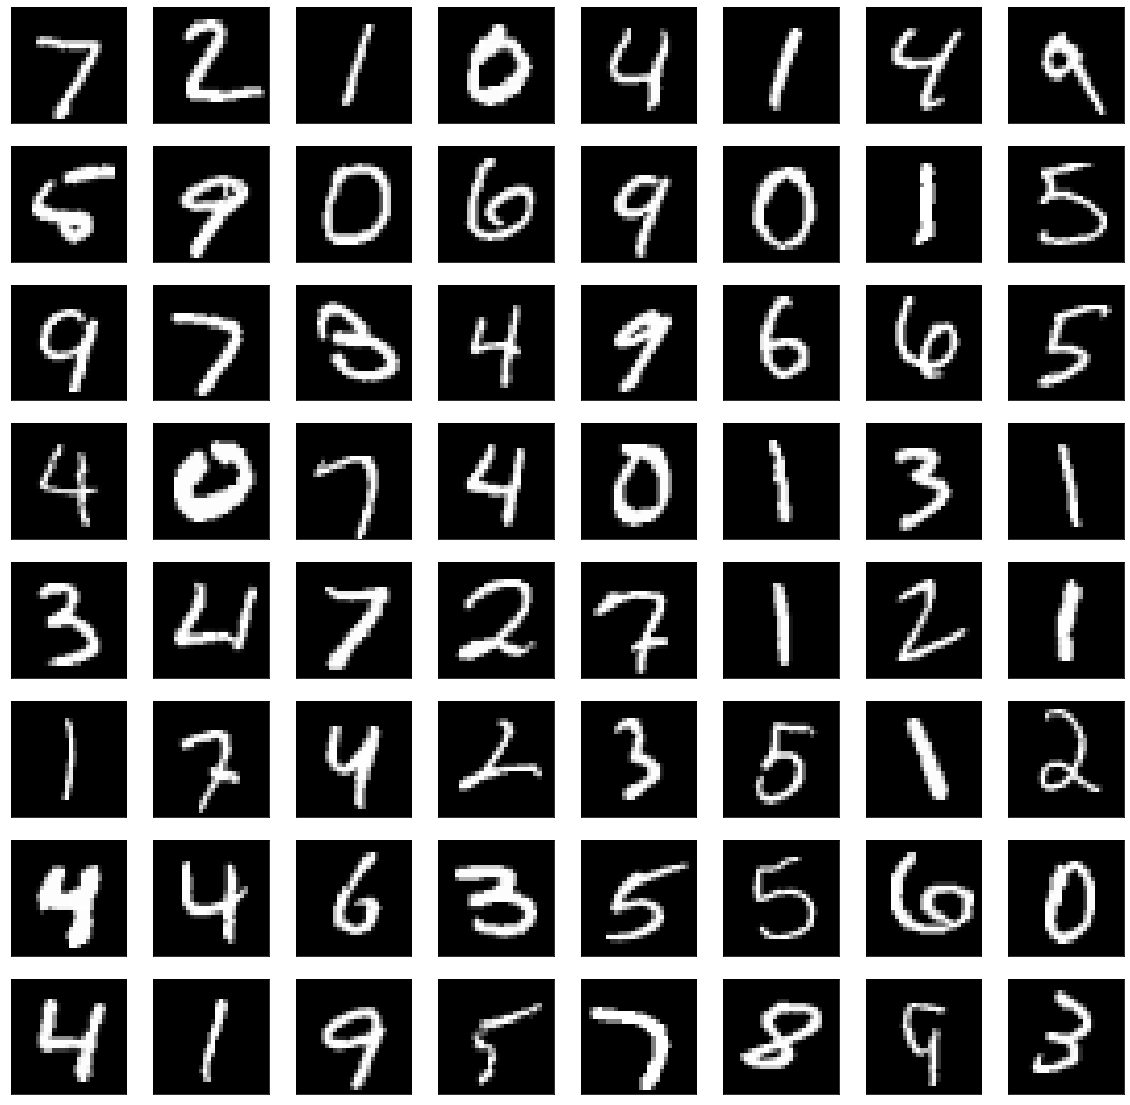

In [1]:
from tensorflow.keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, _), (test_images, _) = datasets.mnist.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_images[i], cmap="gray" )

다음과 같이 입력 데이터의 전처리를 해줍니다. 2차원 이미지를 1차원 데이터로 만들어 주고 최대값으로 나누어 정규화를 하고 double precision 까지는 필요가 없으므로 float32 자료형으로 변환합니다.

In [2]:
_, H, W = train_images.shape
train_x = ( train_images.reshape(-1, H * W) / 255 ).astype('float32')
test_x = ( test_images.reshape(-1, H * W) / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 784) float32


인코더, 디코더, 그 둘을 합쳐 오토 인코더를 만듭니다. 출력을 0~1 로 한정짓기 위해서 마지막 층에 sigmoid 활성함수를 사용했습니다. loss 함수로 mse 를 사용해도 되지만 필기체 이미지의 픽셀값들이 0 이나 1 에 가까운 값들기 많기 때문에 binary_crossentropy 를 사용했습니다.

In [3]:
x = layers.Input( shape=(H*W,), name='x' )
z = layers.Dense( 36, activation='relu', name='z' )(x)
encoder = models.Model(x, z)

z = layers.Input(shape=encoder.get_layer('z').output_shape[1:], name = 'z')
y = layers.Dense( H*W, activation='sigmoid', name='y' )(z)
decoder = models.Model(z, y)

autoencoder = models.Sequential()
autoencoder.add( encoder )
autoencoder.add( decoder )

encoder.summary()
decoder.summary()
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 784)]             0         
_________________________________________________________________
z (Dense)                    (None, 36)                28260     
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               [(None, 36)]              0         
_________________________________________________________________
y (Dense)                    (None, 784)               29008     
Total params: 29,008
Trainable params: 29,008
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
________________

모델을 학습하고 검증합니다.

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2317 - accuracy: 0.7907 - val_loss: 0.1599 - val_accuracy: 0.8045
Epoch 2/20
54000/54000 [==============================] - 1s 25us/sample - loss: 0.1417 - accuracy: 0.8076 - val_loss: 0.1267 - val_accuracy: 0.8100
Epoch 3/20
54000/54000 [==============================] - 1s 24us/sample - loss: 0.1186 - accuracy: 0.8111 - val_loss: 0.1112 - val_accuracy: 0.8123
Epoch 4/20
54000/54000 [==============================] - 1s 24us/sample - loss: 0.1065 - accuracy: 0.8127 - val_loss: 0.1023 - val_accuracy: 0.8137
Epoch 5/20
54000/54000 [==============================] - 1s 24us/sample - loss: 0.0991 - accuracy: 0.8136 - val_loss: 0.0966 - val_accuracy: 0.8141
Epoch 6/20
54000/54000 [==============================] - 1s 23us/sample - loss: 0.0947 - accuracy: 0.8140 - val_loss: 0.0934 - val_accuracy: 0.8144
Epoch 7/20
54000/54000 [==============================] -

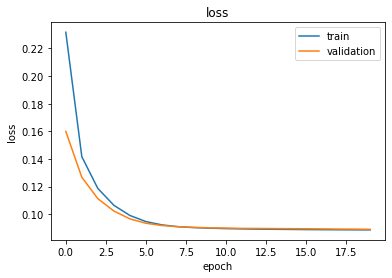

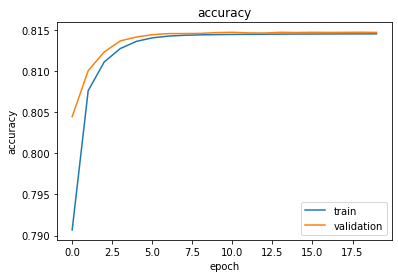

10000/10000 [==============================] - 0s 16us/sample - loss: 0.0874 - accuracy: 0.8136
[loss, accuracy] = [0.08744381713867187, 0.8136266]


In [4]:
hist = autoencoder.fit(train_x, train_x, epochs=20, batch_size=128, validation_split=0.1)

from modules.plot_history import plot_history
plot_history(hist, 'loss')
plot_history(hist, 'accuracy')

performance_test = autoencoder.evaluate( test_x, test_x, batch_size=128)
print( '[loss, accuracy] =', performance_test )

입력이미지를 넣어서 인코딩 된 값을 받고, 그 값을 다시 디코딩해서 원래 이미지와 비슷하게 복원되는지 시각적으로 확인합니다.

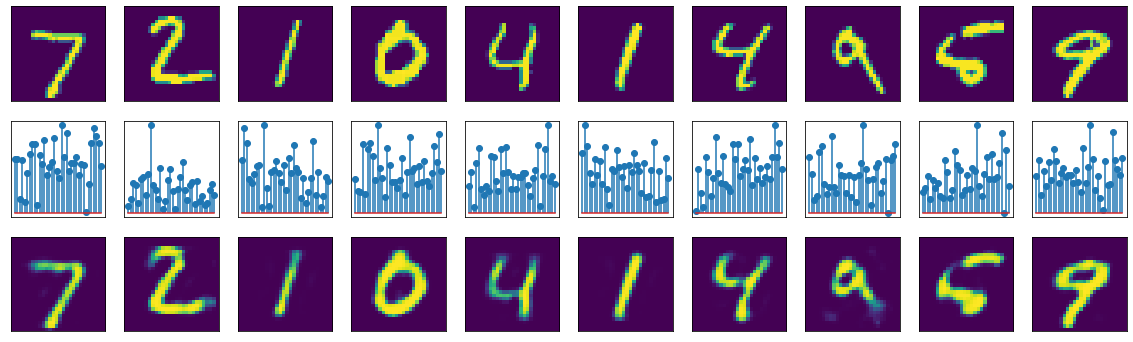

In [5]:
encoded_vals = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_vals)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(test_x[i].reshape(28, 28))

    plt.subplot(3, n, i + 1 + n)
    plt.xticks([]); plt.yticks([])
    plt.stem(encoded_vals[i], use_line_collection=True)

    plt.subplot(3, n, i + 1 + n + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(decoded_imgs[i].reshape(28, 28))

plt.show()